Best parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}
Training set R2 score: 0.9161192736642596
Training set MAE: 0.29286936549549825
Training set MSE: 0.1422551528997603
Training set RMSE: 0.3771672744284163
Test set R2 score: 0.906145650273354
Test set MAE: 0.36992701886063356
Test set MSE: 0.25333590665364264
Test set RMSE: 0.503324852012736


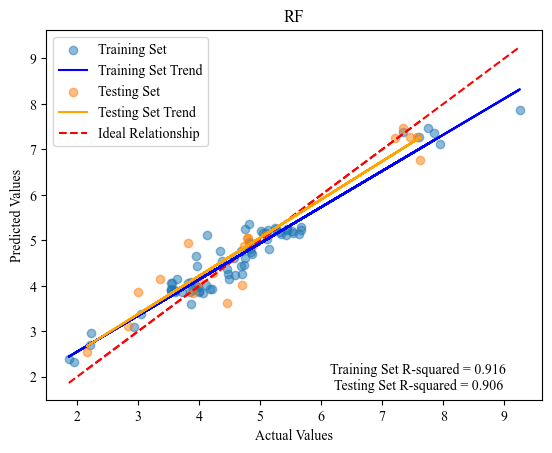

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# Read the CSV file
data = pd.read_csv('23 feature.csv', sep=',')

# Use the first column as the dependent variable and the other columns as the independent variables
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# Divide the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

# Normalize the training and test sets using the mean and standard deviation of the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Decision tree selection features using embedded methods
dt = DecisionTreeRegressor(random_state=5)
dt.fit(X_train_scaled, y_train)

# Select the 15 most important features
feature_importance = pd.Series(dt.feature_importances_, index=X.columns)
top_15_features = feature_importance.nlargest(15).index.tolist()
X_train_selected = X_train[top_15_features]
X_test_selected = X_test[top_15_features]

# Export the selected feature values
X_train_selected.to_csv("selected_features_train.csv", index=False)
X_test_selected.to_csv("selected_features_test.csv", index=False)

# Calculate the correlation matrix
correlation_matrix = X_train_selected.corr()

# Find features with a correlation greater than 0.8
highly_correlated = set()
n_cols = correlation_matrix.shape[1]
for i in range(n_cols):
    for j in range(i + 1, n_cols):
        correlation = correlation_matrix.iloc[i, j]
        if correlation > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            if colname_i not in highly_correlated:
                highly_correlated.add(colname_j)

# Remove features with high relevance
X_train_final = X_train_selected.drop(columns=highly_correlated)
X_test_final = X_test_selected.drop(columns=highly_correlated)

#STD and MEAN for the final feature is obtained
mean_values = X_train_final.mean()
std_values = X_train_final.std()
feature_names = X_train_final.columns.tolist()
data = pd.DataFrame([mean_values, std_values], columns=feature_names)
data.to_csv('mean_std.csv', index=False)


# Export the final list of features
selected_features = X_train_final.columns.tolist()
with open("selected_features.txt", "w") as file:
    file.write("\n".join(selected_features))

    
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Specify the font properties
font_properties = fm.FontProperties(family="Times New Roman", size=10)

# Calculate the correlation matrix after removing highly correlated features
correlation_matrix_final = X_train_final.corr()

# Create the heatmap
ax = sns.heatmap(correlation_matrix_final, annot=False, cmap="coolwarm")

# Set the font properties for the annotations
for text in ax.texts:
    text.set_fontproperties(font_properties)

plt.title("Correlation Matrix of Selected Features (After Removing Highly Correlated Features)")
plt.savefig('1.jpg', dpi=300, bbox_inches='tight')
plt.close()

# Create the heatmap of the original selected features correlation matrix
ax = sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")

# Set the font properties for the annotations
for text in ax.texts:
    text.set_fontproperties(font_properties)

plt.title("Correlation Matrix of Selected Features")
plt.savefig('2.jpg', dpi=300, bbox_inches='tight')
plt.close()

# Define random forest regression models and hyperparameter spaces
model = RandomForestRegressor(random_state=42)
params = {'n_estimators': [150],
          'max_depth': [4],
          'min_samples_split': [3],
          'min_samples_leaf': [1]} 

# Use grid search and 5-fold cross-validation to find the optimal hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5)
grid_search.fit(X_train_final, y_train)

# Output the optimal hyperparameters
print("Best parameters:", grid_search.best_params_)

# Get the optimal model
best_model = grid_search.best_estimator_

# Use the training set to calculate metrics such as R-square, MAE, MSE, and RMSE
y_train_pred = best_model.predict(X_train_final)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

print("Training set R2 score:", r2_train)
print("Training set MAE:", mae_train)
print("Training set MSE:", mse_train)
print("Training set RMSE:", rmse_train)

# Use the test set to calculate metrics such as R-square, MAE, MSE, and RMSE
y_test_pred = best_model.predict(X_test_final)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("Test set R2 score:", r2_test)
print("Test set MAE:", mae_test)
print("Test set MSE:", mse_test)
print("Test set RMSE:", rmse_test)

joblib.dump(best_model, 'RF.joblib')

# Export the prediction results of the training set as a CSV file containing the index number of the original data
train_predictions = pd.DataFrame({'Index': X_train_final.index, 'Actual': y_train, 'Predicted': y_train_pred})
train_predictions.to_csv('train_predictions.csv', index=False)

# Export the prediction results of the test set as a CSV file containing the index number of the original data
test_predictions = pd.DataFrame({'Index': X_test_final.index, 'Actual': y_test, 'Predicted': y_test_pred})
test_predictions.to_csv('test_predictions.csv', index=False)

from joblib import dump

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# plot training set actual vs predicted values
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Training Set')

z_train = np.polyfit(y_train, y_train_pred, 1)
p_train = np.poly1d(z_train)
plt.plot(y_train, p_train(y_train), '-', color='blue', label='Training Set Trend')

# plot testing set actual vs predicted values
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Testing Set')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
z_test = np.polyfit(y_test, y_test_pred, 1)
p_test = np.poly1d(z_test)
plt.plot(y_test, p_test(y_test), '-', color='orange', label='Testing Set Trend')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label='Ideal Relationship')
# set axis labels and legend
plt.xlabel('Actual Values', fontname='Times New Roman')
plt.ylabel('Predicted Values', fontname='Times New Roman')
plt.legend()

# compute and display R-squared values
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
plt.text(0.75, 0.1, f'Training Set R-squared = {train_r2:.3f}\nTesting Set R-squared = {test_r2:.3f}', 
         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes, fontname='Times New Roman')

# plot trend lines with blue and orange colors
plt.plot(y_train, p_train(y_train), '-', color='blue', label='Training Set Trend')
plt.plot(y_test, p_test(y_test), '-', color='orange', label='Testing Set Trend')
# add title
plt.title('RF', fontname='Times New Roman')

# save plot as JPG file
plt.savefig('my_plot.jpg', dpi=300, bbox_inches='tight')
